In [1]:
!nvidia-smi

Sat Nov 19 12:05:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.01    Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8    12W /  N/A |    184MiB /  8192MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#First load libraries and images
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import kornia
import cv2
from kornia.feature import *
from time import time
import torch.optim as optim
from torch.nn import Parameter
from kornia.color import rgb_to_grayscale
import torchvision.transforms as T

from pathlib import Path

# data_dir = Path('/app/notebooks/image_stitching/sample_data/keyboard')
data_dir = Path('/app/notebooks/image_stitching/sample_data/keyboard_1-camera')
assert data_dir.exists()

In [3]:
device = torch.device('cpu')

In [4]:
available_exts = ['.jpg', '.png']

def load_dir(dir_path, size=(256, 256)):
    dir_path = Path(dir_path)
    
    resize_f = T.Resize(size)
    
    imgs = []
    for file_path in dir_path.iterdir():
        if file_path.suffix not in available_exts:
            continue
        
        i_img = Image.open(file_path)
        i_timg = kornia.utils.image_to_tensor(np.array(i_img), False).float() / 255.
        i_timg = i_timg.to(device)
        i_timg = resize_f(i_timg[:, :3, :, :])
        imgs.append(i_timg)
        
    timg = torch.cat(imgs, dim=0)
    timg_gray = kornia.color.rgb_to_grayscale(timg)
    return timg, timg_gray

def torch_resize(img, scale_factor):
    width = int(img.shape[3] * scale_factor)
    height = int(img.shape[2] * scale_factor)
    dim = (height, width)
    
    resize_f = T.Resize(dim)

    # resize image
    resized = resize_f(img)
    return resized

def drop_by_idx(t, idx):
    return torch.cat([t[0:idx], t[idx+1:]])

In [5]:
def visualize_LAF(img, LAF, img_idx = 0):
    x, y = kornia.feature.laf.get_laf_pts_to_draw(LAF, img_idx)
    plt.figure()
    plt.imshow(kornia.utils.tensor_to_image(img[img_idx]))
    plt.plot(x, y, 'r')
    plt.show()
    return

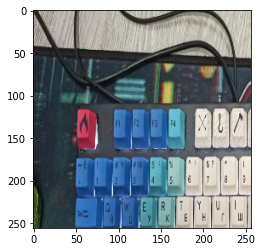

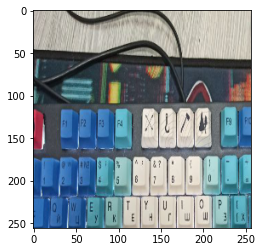

In [6]:
timg, timg_gray = load_dir(data_dir)
timg, timg_gray = torch_resize(timg, 1), torch_resize(timg_gray, 1)

plt.imshow(kornia.utils.tensor_to_image(timg[0]))
plt.figure()
plt.imshow(kornia.utils.tensor_to_image(timg[1]))

In [7]:
timg.shape

torch.Size([10, 3, 256, 256])

In [8]:
from kornia.contrib import ImageStitcher
import kornia.feature as KF
import kornia as K

IS = ImageStitcher(KF.LoFTR(pretrained='outdoor'), estimator='ransac')

In [15]:
timg[0][None].shape

torch.Size([1, 3, 256, 256])

In [24]:
in_imgs = []

for i in range(timg.shape[0]-3):
    in_imgs.append(timg[i][None])

In [25]:
# NOTE: it would require a large CPU memory if many images.
with torch.no_grad():
    out = IS(*in_imgs)

In [26]:
out.shape

torch.Size([1, 3, 256, 506])

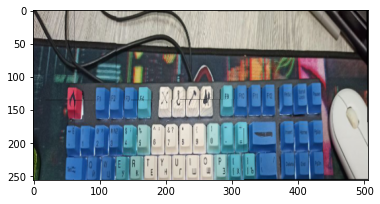

In [27]:
plt.imshow(K.tensor_to_image(out))
plt.show()